<a href="https://colab.research.google.com/github/NicholasBaraghini/Ball-and-Beam-system-Optimal-Control/blob/main/OPTCON_Grp21_Ball_and_Beam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTIMAL CONTROL EXAM PROJECT**

 Group 21:
   - Baraghini Nicholas 0000984041 
   - Curto Fabio
   - Iadarola Federico

In [1]:
# Libraries
import numpy as np
import matplotlib

import system_dynamic as sd
import optcon as opt
import cost_function
import matplotlib.pyplot as plt_

%matplotlib widget

import visualization as visu

**TRAJECTORY EXPLORATION** (Task 1)

In [2]:
# PARAMETERS SETTING
BB = 0 #flag for b&b
max_iterations = 200;
STOP_ITER = 1E-6; #Stop Iteration descent threshold

step_size = 1;
cc = 0.05
beta = 0.5

nx = 2 # nmumber of states
nu = 1 # number of inputs
tf = 30 # Seconds

params = {'dt':0.001,   # Step size - Forward Euler method
          'gg':9.81,    # gravitational acceleration [m/s^2]
          'mm':0.12,    # ball mass [kg]
          'rr':0.015,   # ball radius [m]
          'ii':11.6E-6, # ball inertia [kg*m^2]
          'II':0.1125,  # beam inertia [kg*m^2]
          'LL':1,        # beam lenght [m]
          'QQ': np.array([[100,0],
                            [0,40]]),
          'RR':1,
          'QQ_T':np.array([[10,0],
                            [0,100]])
              }



TT = int(tf/params['dt']); # rounding down of the time span divided in time in number oof time intervals

xx_init = np.zeros((nx,1)); # initial state


**Reference Definition** \
Step reference change between two equilibria 

In [3]:
if BB :
    # REFERENCE DEFINITION
    ref_pos = 0.3; # ball reference position on the beam [m]
    ref_inp = params['mm']*params['gg']*ref_pos; # input reference torque at reference pos ref_pos

    # state reference definition:
    xx_ref = np.zeros((nx,TT));
    xx_ref[0,round(TT/2):TT] = ref_pos;

    # input reference definition
    uu_ref = np.zeros((nu,TT));
    uu_ref[0,round(TT/2):TT] = ref_inp;
    xx = np.zeros((nx,TT,max_iterations)); # state tensor uu = np.zeros((nu,TT,max_iterations)); # input tensor

    cost = np.zeros((max_iterations,1)); # cost function values memory descent = np.zeros((max_iterations,1));
else:
    ref_deg = 160
    xx_ref = np.zeros((2,TT));   #nx = 2
    xx_ref[0,round(TT/2):TT] = np.radians(ref_deg)

    uu_ref = np.zeros((1,TT));
    K_eq = 9.8 #mm*gg*ll
    uu_ref[0,round(TT/2):TT] = -K_eq*np.sin(xx_ref[0, round(TT/2):TT ])



**OPTIMIZATION LOOP**

In [4]:
## ITERATION LOOP

# Initializations
xx = np.zeros((nx,TT,max_iterations)) # state tensor
uu = np.zeros((nu,TT,max_iterations)) # input tensor

cost = np.zeros(max_iterations) # cost function values memory

descent = np.zeros(max_iterations) # descent vector

#initialize trajectory
kk = 0
for tt in range(0,TT-1):

    uu_tk = uu[:, tt:tt + 1, kk:kk + 1] # shape (1,1,1)
    uu_ref_tt = uu_ref[:, tt:tt + 1] # shape (1,1)
    xx_tk = xx[:, tt:tt + 1, kk:kk + 1] # shape (4,1,1)
    xx_ref_tt = xx_ref[:, tt:tt + 1] # shape (4,1)

    cost_temp = cost_function.Stage_Cost(xx_tk, uu_tk, xx_ref_tt, uu_ref_tt, params)['cost_t']
    cost[kk] = cost[kk] + cost_temp[0]

xx_Tk = xx[:,TT-1:TT,kk:kk+1]
xx_ref_TT = xx_ref[:,TT-1:TT]
cost_temp = cost_function.Terminal_Cost(xx_Tk, xx_ref_TT,params)['cost_T']

cost[kk] = cost[kk] + cost_temp[0]

# LOOP
for kk in range(0,max_iterations-1):

    KK = np.zeros((nu,nx,TT))
    SS = np.zeros((nu,TT)) #Sigma
    pp = np.zeros((nx,TT))
    PP = np.zeros((nx,nx,TT))
    dd = 0
    # Computation of the K, p, P, Sigma, and descent
    KK,SS,PP,pp,dd = opt.DDP_comp_t_k(kk, xx, uu, xx_ref, uu_ref, TT, params).values()
    gammas = opt.Armijo(kk, xx, uu, xx_init, xx_ref, uu_ref, TT, cost, descent[kk], cc, beta, SS, KK, pp, params)
    xx,uu,cost = opt.Trajectory_Update(kk, xx, uu, xx_ref, uu_ref, xx_init, TT, cost, gammas[-1], SS, KK, pp, params).values()

    dd = np.reshape(dd, 1)

    print('iteration:', kk )
    print('cost', cost[kk])
    print('descent', dd)

    if np.abs(dd)<STOP_ITER: #STOP CRITERION
       Max_Iter = kk
       print("GG WP")
       break
    descent[kk] = dd
    Max_Iter = kk


DDP_comp FINISHED
ARMIJO found
iteration: 0
cost 11865114.034348622
descent [-7277083.10389067]
DDP_comp FINISHED
ARMIJO found
iteration: 1
cost 3873195.4335869504
descent [-1664841.25212388]
DDP_comp FINISHED
ARMIJO found
iteration: 2
cost 1536308.5630645675
descent [-963120.55923305]
DDP_comp FINISHED
ARMIJO found
iteration: 3
cost 389577.32550066017
descent [-77726.14285837]
DDP_comp FINISHED
ARMIJO found
iteration: 4
cost 309402.05330049153
descent [-112.07725181]
DDP_comp FINISHED
ARMIJO found
iteration: 5
cost 309288.9530198377
descent [-0.00202209]
DDP_comp FINISHED
ARMIJO found
iteration: 6
cost 309288.95098121127
descent [-8.6173907e-12]
GG WP


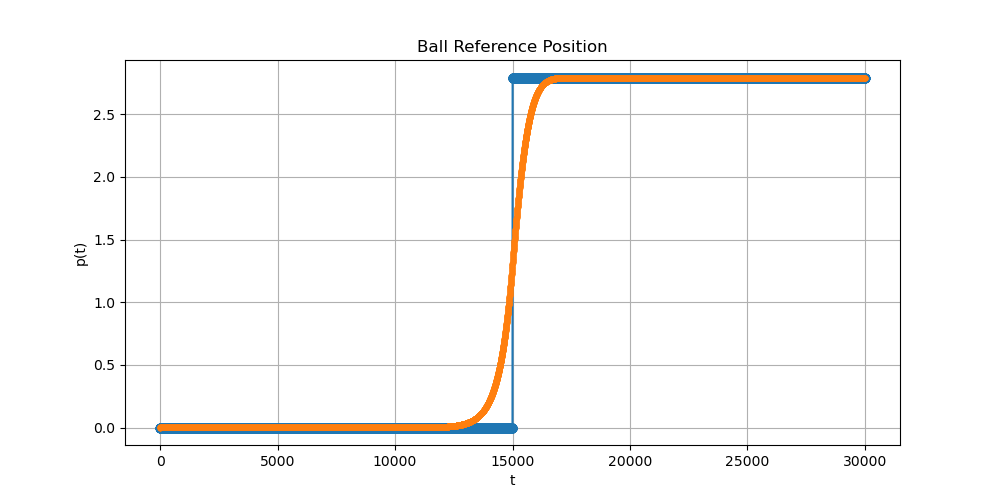

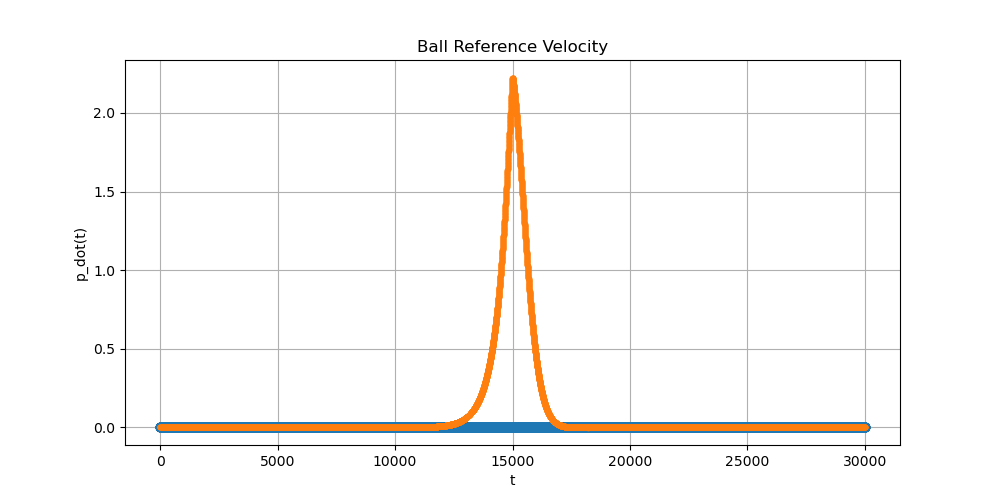

IndexError: index 2 is out of bounds for axis 0 with size 2

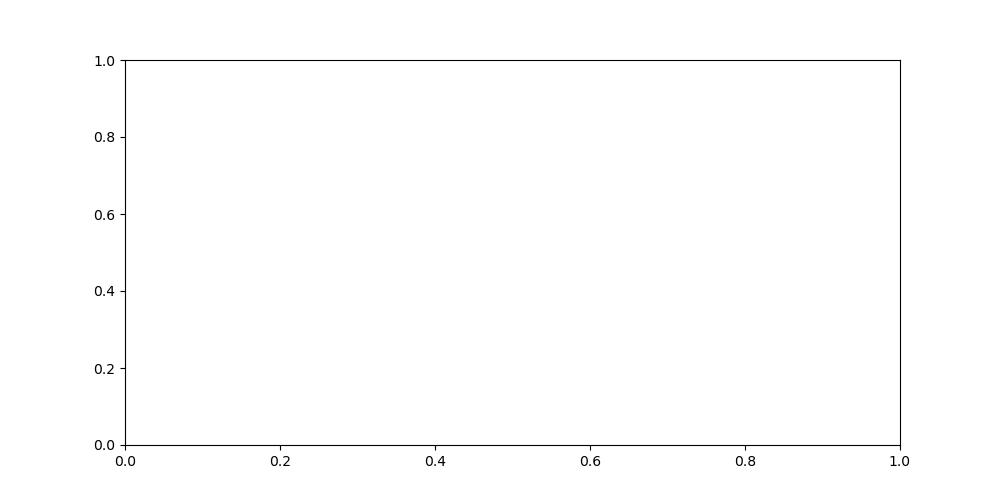

In [5]:
# Plotting the Graph
t = range(0,TT)
fig0, ax0 = plt_.subplots(figsize=(10, 5))
ax0.plot(t, xx_ref[0, :], 'o-', label='xx_ref_0')
ax0.plot(t, xx[0, :,Max_Iter], '.-', label='xx_0')
plt_.title("Ball Reference Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig1, ax1 = plt_.subplots(figsize=(10, 5))
ax1.plot(t, xx_ref[1, :], 'o-', label='xx_ref_1')
ax1.plot(t, xx[1, :,Max_Iter], '.-', label='xx_1')
plt_.title("Ball Reference Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig2, ax2 = plt_.subplots(figsize=(10, 5))
ax2.plot(t, xx_ref[2, :], 'o-', label='xx_ref_2')
ax2.plot(t, xx[2, :,Max_Iter], '.-', label='xx_2')
plt_.title("Beam Reference Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig3, ax3 = plt_.subplots(figsize=(10, 5))
ax3.plot(t, xx_ref[3, :], 'o-', label='xx_ref_3')
ax3.plot(t, xx[3, :,Max_Iter], '.-', label='xx_3')
plt_.title("Beam Reference velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig, ax = plt_.subplots(figsize=(10, 5))
ax.plot(t, uu_ref[0, :], 'o-', label='uu_ref')
ax.plot(t, uu[0, :,Max_Iter], '.-', label='uu')
plt_.title("Input Torque")
plt_.xlabel("t")
plt_.ylabel("torque(t)")
plt_.grid()
plt_.show()

**TRAJECTORY OPTIMIZATION** (Task 2)

**TRAJECTORY TRACKING** (Task 3)